基于加权傅里叶变换的策略。对滚动窗口内的数据进行fft，通过计算以功率谱为参考，计算该段信号内的加权平均周期。如果周期大于阈值，则说明目前存在明显趋势，使用线性回归策略判断多空方向进行开平仓；如果小于阈值，则说明市场处于震荡阶段不操作。辅助以止盈止损策略。

20180601-20181127  
Sharpe Ratio：2.43  
总收益率：56.6%  
年化收益：75.46%  
百分比最大回撤: -9.36%  

20180110-20181127  
Sharpe Ratio：0.86  
总收益率：90.64%  
年化收益：67.56%  
百分比最大回撤: -28.79%  

## 配置引擎参数

In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 05:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from scipy.fftpack import fft,ifft
from math import log as ln
from sklearn import linear_model
########################################################################
# 策略继承CtaTemplate
class FourierStrategy(CtaTemplate):
    """Fourier策略"""
    className = 'FourierStrategy'
    author = 'xiaotao'
    
    # 策略参数
    signalPeriod = 90     # 偶数
    lot = 100             # 设置手数
    q = 10    
    stopLossPct = 0.1 #1毛
    takeProfitPct = 0.3 #3毛
    proportion = 0.7
    
    # 策略变量
    transactionPrice = {} # 记录成交价格

    # 参数列表
    paramList = ['signalPeriod','q','proportion']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        N = self.signalPeriod        
        Fs = 1
        y = am60.close[-(N+1):-1]
        yy = fft(y);
        old_array = abs(yy[1:int(N/2)]/N*2)
        old_array = old_array.tolist()
        old_array.insert(0,abs(yy[0])/N)
        #print('old_array:',old_array)
        power = [np.power(l,2) for l in old_array]
        S = np.zeros(len(power))
        K = np.zeros(len(power))
        T = np.zeros(len(power))
        for j in range(len(power)):
            S[j] = ln(power[j])
            if S[j] > self.q:
                K[j] = S[j] - self.q
                if j != 0:
                    T[j] = N/Fs/j
                else:
                    T[j] = np.inf
            else:
                K[j] = 0.00001

        #print('T:',T,type(T))
        #print('S:',S)
        #print('K:',K,type(K))        
        WT = np.dot(K[1:],T[1:])/sum(K[1:])
        #print('WT:',WT)
        if WT > self.q*self.proportion:
            regr = linear_model.LinearRegression()
                # 拟合
            regr.fit(np.arange(0,N).reshape(-1, 1),y) 
            a, b = regr.coef_, regr.intercept_

            #print('a:',a)
        else:
            a = 0
        crossOver = a>0
        crossBelow = a<=0
        
        
        # 构建进出场逻辑-------------------------------------------------

        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)

        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(FourierStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function FourierStrategy.on60MinBar at 0x00000204E0B4BB70>, <__main__.FourierStrategy object at 0x00000204E04A2550>)
2018-12-23 12:46:22.436208	开始回测
2018-12-23 12:46:22.436208	策略初始化
2018-12-23 12:46:22.437204	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-23 12:46:24.547956	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 12:46:24.551013	载入完成，数据量：12000
2018-12-23 12:46:24.551013	策略初始化完成
2018-12-23 12:46:24.551013	策略启动完成
2018-12-23 12:46:24.551013	开始回放回测数据,回测范围:[20180601 00:00,20181127 05:59)
2018-12-23 12:46:24.570896	载入历史数据。数据范围:[20180601 00:00,20181127 05:59)
2018-12-23 12:46:38.057602	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 12:46:38.113505	载入完成，数据量：256327
2018-12-23 12:46:38.113505	当前回放数据:[20180601 00:00,20181127 05:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-23 12:46:38.114481	载入历史数据。数据范围:[20180531 08:51,20180603

In [4]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-01 01:00:00,空,,,0.0,,开仓,1,,7551.99,0.0,None,,,1,2018-06-01 01:00:00,100,1,BTCUSDT:binance,1
2018-06-01 12:00:00,多,,,0.0,,平仓,2,,7495.13,0.0,None,,,2,2018-06-01 12:00:00,100,2,BTCUSDT:binance,2
2018-06-01 12:00:00,多,,,0.0,,开仓,3,,7495.13,0.0,None,,,3,2018-06-01 12:00:00,100,3,BTCUSDT:binance,3
2018-06-01 22:00:00,空,,,0.0,,平仓,4,,7430.00,0.0,None,,,4,2018-06-01 22:00:00,100,4,BTCUSDT:binance,4
2018-06-01 22:00:00,空,,,0.0,,开仓,5,,7430.00,0.0,None,,,5,2018-06-01 22:00:00,100,5,BTCUSDT:binance,5
2018-06-30 22:00:00,多,,,0.0,,平仓,6,,6397.50,0.0,None,,,6,2018-06-30 22:00:00,100,6,BTCUSDT:binance,6
2018-06-30 22:00:00,多,,,0.0,,开仓,7,,6397.50,0.0,None,,,7,2018-06-30 22:00:00,100,7,BTCUSDT:binance,7
2018-07-03 16:00:00,空,,,0.0,,平仓,8,,6644.21,0.0,None,,,8,2018-07-03 16:00:00,100,8,BTCUSDT:binance,8
2018-07-03 16:00:00,空,,,0.0,,开仓,9,,6644.21,0.0,None,,,9,2018-07-03 16:00:00,100,9,BTCUSDT:binance,9


2018-12-23 12:47:03.046633	计算按日统计结果
2018-12-23 12:47:03.145369	------------------------------
2018-12-23 12:47:03.146366	首个交易日：	2018-06-01 00:00:00
2018-12-23 12:47:03.146366	最后交易日：	2018-11-27 00:00:00
2018-12-23 12:47:03.146366	总交易日：	180
2018-12-23 12:47:03.146366	盈利交易日	103
2018-12-23 12:47:03.146366	亏损交易日：	76
2018-12-23 12:47:03.146366	起始资金：	1000000
2018-12-23 12:47:03.146366	结束资金：	1,565,961.77
2018-12-23 12:47:03.146366	总收益率：	56.6%
2018-12-23 12:47:03.146366	年化收益：	75.46%
2018-12-23 12:47:03.146366	总盈亏：	565,961.77
2018-12-23 12:47:03.146366	最大回撤: 	-129,765.75
2018-12-23 12:47:03.146366	百分比最大回撤: -9.36%
2018-12-23 12:47:03.146366	总手续费：	15,696.23
2018-12-23 12:47:03.146366	总滑点：	9.0
2018-12-23 12:47:03.146366	总成交金额：	31,392,467.0
2018-12-23 12:47:03.146366	总成交笔数：	45
2018-12-23 12:47:03.146366	日均盈亏：	3,144.23
2018-12-23 12:47:03.146366	日均手续费：	87.2
2018-12-23 12:47:03.146366	日均滑点：	0.05
2018-12-23 12:47:03.146366	日均成交金额：	174,402.59
2018-12-23 12:47:03.147364	日均成交笔数：	0.25
2018-12-23 12:47:03.1

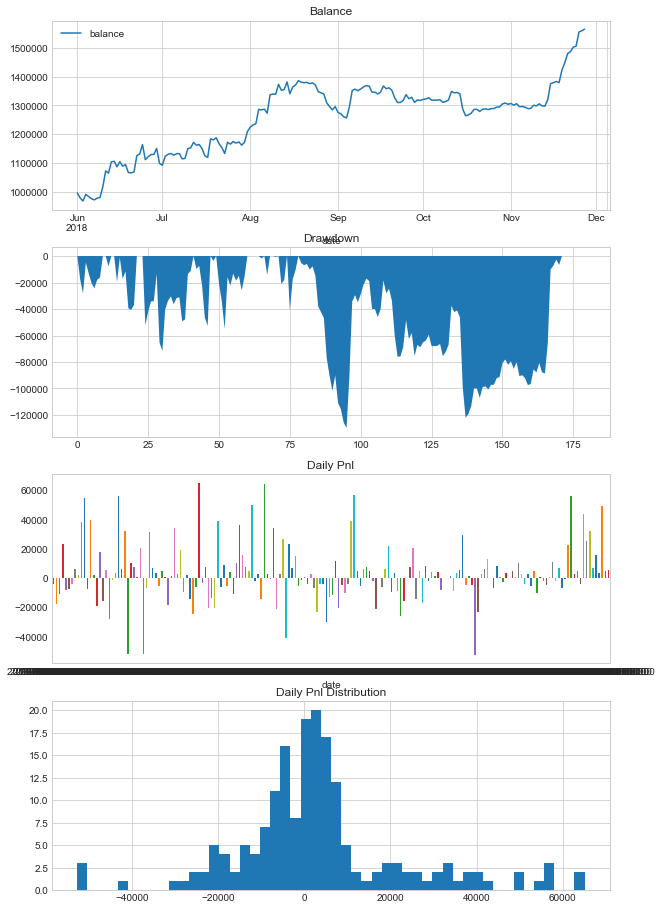

In [5]:
                                                                                                                                    # 显示逐日回测结果
engine.showDailyResult()

下面对EOS进行回测

In [6]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180610 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 05:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [7]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from scipy.fftpack import fft,ifft
from math import log as ln
from sklearn import linear_model
########################################################################
# 策略继承CtaTemplate
class FourierStrategy(CtaTemplate):
    """Fourier策略"""
    className = 'FourierStrategy'
    author = 'xiaotao'
    
    # 策略参数
    signalPeriod = 10     # 偶数
    lot = 100             # 设置手数
    q = 5    
    stopLossPct = 0.1 #1毛
    takeProfitPct = 0.3 #3毛
    proportion = 0.7
    
    # 策略变量
    transactionPrice = {} # 记录成交价格

    # 参数列表
    paramList = ['signalPeriod','q','proportion']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        N = self.signalPeriod        
        Fs = 1
        y = am60.close[-(N+1):-1]
        yy = fft(y);
        old_array = abs(yy[1:int(N/2)]/N*2)
        old_array = old_array.tolist()
        old_array.insert(0,abs(yy[0])/N)
        #print('old_array:',old_array)
        power = [np.power(l,2) for l in old_array]
        S = np.zeros(len(power))
        K = np.zeros(len(power))
        T = np.zeros(len(power))
        for j in range(len(power)):
            S[j] = ln(power[j])
            if S[j] > self.q:
                K[j] = S[j] - self.q
                if j != 0:
                    T[j] = N/Fs/j
                else:
                    T[j] = np.inf
            else:
                K[j] = 0.00001

        #print('T:',T,type(T))
        #print('S:',S)
        #print('K:',K,type(K))        
        WT = np.dot(K[1:],T[1:])/sum(K[1:])
        #print('WT:',WT)
        if WT > self.q*self.proportion:
            regr = linear_model.LinearRegression()
                # 拟合
            regr.fit(np.arange(0,N).reshape(-1, 1),y) 
            a, b = regr.coef_, regr.intercept_

            #print('a:',a)
        else:
            a = 0
        crossOver = a>0
        crossBelow = a<=0
        
        
        # 构建进出场逻辑-------------------------------------------------

        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)

        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [8]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(FourierStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function FourierStrategy.on60MinBar at 0x00000204F3F10D08>, <__main__.FourierStrategy object at 0x00000204F27B9320>)
2018-12-23 12:47:06.239097	开始回测
2018-12-23 12:47:06.239097	策略初始化
2018-12-23 12:47:06.241091	载入历史数据。数据范围:[20180601 16:00,20180610 00:00)
2018-12-23 12:47:07.195540	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 12:47:07.198534	载入完成，数据量：12000
2018-12-23 12:47:07.200535	策略初始化完成
2018-12-23 12:47:07.202521	策略启动完成
2018-12-23 12:47:07.202521	开始回放回测数据,回测范围:[20180610 00:00,20181127 05:59)
2018-12-23 12:47:07.241417	载入历史数据。数据范围:[20180610 00:00,20181127 05:59)
2018-12-23 12:47:25.188428	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 12:47:25.250260	载入完成，数据量：243367
2018-12-23 12:47:25.251259	当前回放数据:[20180610 00:00,20181127 05:59)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180610000000
2018-12-23 12:47:25.252260	载入历史数据。数据范围:[20180609 08:51,20180612

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 12:47:40.577276	数据回放结束ss: 100%    


In [9]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-10 01:00:00,空,,,0.0,,开仓,1,,14.2689,0.0,None,,,1,2018-06-10 01:00:00,100,1,EOSUSDT:binance,1


2018-12-23 12:47:40.628142	计算按日统计结果
2018-12-23 12:47:40.681997	------------------------------
2018-12-23 12:47:40.681997	首个交易日：	2018-06-10 00:00:00
2018-12-23 12:47:40.681997	最后交易日：	2018-11-27 00:00:00
2018-12-23 12:47:40.681997	总交易日：	171
2018-12-23 12:47:40.681997	盈利交易日	92
2018-12-23 12:47:40.681997	亏损交易日：	79
2018-12-23 12:47:40.681997	起始资金：	1000000
2018-12-23 12:47:40.681997	结束资金：	1,001,108.72
2018-12-23 12:47:40.682993	总收益率：	0.11%
2018-12-23 12:47:40.682993	年化收益：	0.16%
2018-12-23 12:47:40.682993	总盈亏：	1,108.72
2018-12-23 12:47:40.682993	最大回撤: 	-237.68
2018-12-23 12:47:40.682993	百分比最大回撤: -0.02%
2018-12-23 12:47:40.682993	总手续费：	0.71
2018-12-23 12:47:40.682993	总滑点：	0.2
2018-12-23 12:47:40.682993	总成交金额：	1,426.89
2018-12-23 12:47:40.682993	总成交笔数：	1
2018-12-23 12:47:40.682993	日均盈亏：	6.48
2018-12-23 12:47:40.682993	日均手续费：	0.0
2018-12-23 12:47:40.683991	日均滑点：	0.0
2018-12-23 12:47:40.683991	日均成交金额：	8.34
2018-12-23 12:47:40.683991	日均成交笔数：	0.01
2018-12-23 12:47:40.683991	日均收益率：	0.0%
2018-12-23 1

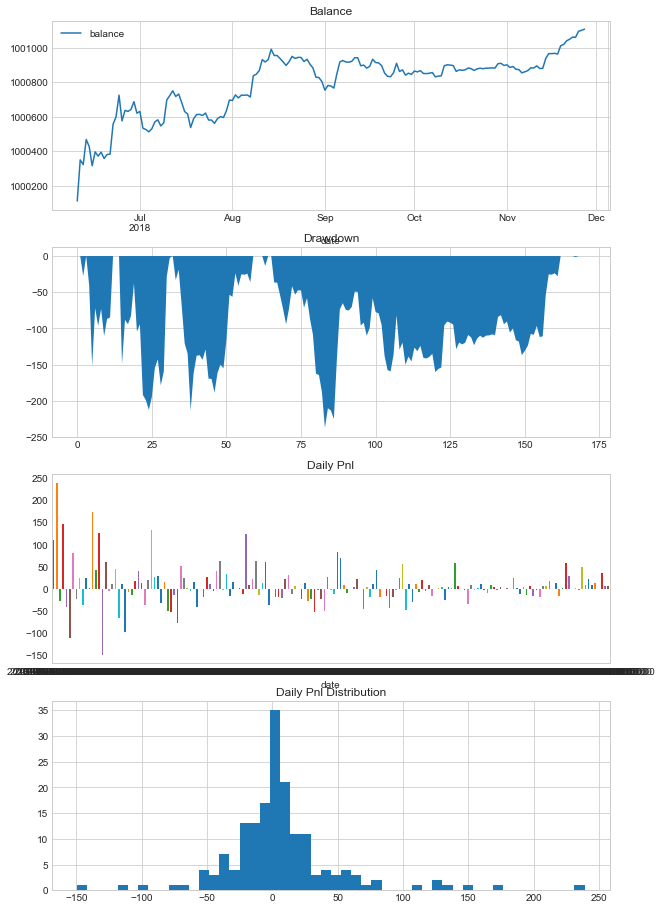

In [10]:
# 显示逐日回测结果
engine.showDailyResult()

优化部分

In [28]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
setting.addParameter('signalPeriod', 10,100, 20)    
setting.addParameter('q', 5, 15, 3)   
setting.addParameter('proportion', 0.7, 0.95, 0.05)   
setting.addParameter('symbolList', ['EOSUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(FourierStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-23 08:50:23.361516	------------------------------
2018-12-23 08:50:23.361516	setting: {'signalPeriod': 10, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function FourierStrategy.on60MinBar at 0x0000025082F20E18>, <__main__.FourierStrategy object at 0x0000025082B6D898>)
2018-12-23 08:50:23.377471	开始回测
2018-12-23 08:50:23.377471	策略初始化
2018-12-23 08:50:23.378467	载入历史数据。数据范围:[20180601 16:00,20180610 00:00)
2018-12-23 08:50:23.900676	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 08:50:23.903670	载入完成，数据量：12000
2018-12-23 08:50:23.904667	策略初始化完成
2018-12-23 08:50:23.904667	策略启动完成
2018-12-23 08:50:23.904667	开始回放回测数据,回测范围:[20180610 00:00,20181127 05:59)
2018-12-23 08:50:23.921656	载入历史数据。数据范围:[20180610 00:00,20181127 05:59)
2018-12-23 08:50:34.967816	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-23 08:50:35.020708	载入完成，数据量：243367
2018-12-23 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:50:46.192569	数据回放结束ss: 100%    
2018-12-23 08:50:46.192569	计算按日统计结果
2018-12-23 08:50:46.306264	------------------------------
2018-12-23 08:50:46.306264	setting: {'signalPeriod': 10, 'q': 5, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:51:08.624694	数据回放结束ss: 100%    
2018-12-23 08:51:08.624694	计算按日统计结果
2018-12-23 08:51:08.742376	------------------------------
2018-12-23 08:51:08.742376	setting: {'signalPeriod': 10, 'q': 5, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:51:30.373942	数据回放结束ss: 100%    
2018-12-23 08:51:30.373942	计算按日统计结果
2018-12-23 08:51:30.496611	------------------------------
2018-12-23 08:51:30.496611	setting: {'signalPeriod': 10, 'q': 5, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:51:52.211949	数据回放结束ss: 100%    
2018-12-23 08:51:52.211949	计算按日统计结果
2018-12-23 08:51:52.321686	------------------------------
2018-12-23 08:51:52.322652	setting: {'signalPeriod': 10, 'q': 5, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:52:15.052399	数据回放结束ss: 100%    
2018-12-23 08:52:15.052399	计算按日统计结果
2018-12-23 08:52:15.166094	------------------------------
2018-12-23 08:52:15.166094	setting: {'signalPeriod': 10, 'q': 8, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:52:39.060717	数据回放结束ss: 100%    
2018-12-23 08:52:39.060717	计算按日统计结果
2018-12-23 08:52:39.180367	------------------------------
2018-12-23 08:52:39.180367	setting: {'signalPeriod': 10, 'q': 8, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:53:02.931962	数据回放结束ss: 100%    
2018-12-23 08:53:02.931962	计算按日统计结果
2018-12-23 08:53:03.034657	------------------------------
2018-12-23 08:53:03.034657	setting: {'signalPeriod': 10, 'q': 8, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:53:25.765785	数据回放结束ss: 100%    
2018-12-23 08:53:25.765785	计算按日统计结果
2018-12-23 08:53:25.941324	------------------------------
2018-12-23 08:53:25.941324	setting: {'signalPeriod': 10, 'q': 8, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:53:47.612399	数据回放结束ss: 100%    
2018-12-23 08:53:47.612399	计算按日统计结果
2018-12-23 08:53:47.714125	------------------------------
2018-12-23 08:53:47.714125	setting: {'signalPeriod': 10, 'q': 8, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:54:08.989445	数据回放结束ss: 100%    
2018-12-23 08:54:08.989445	计算按日统计结果
2018-12-23 08:54:09.094163	------------------------------
2018-12-23 08:54:09.094163	setting: {'signalPeriod': 10, 'q': 11, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:54:32.513982	数据回放结束ss: 100%    
2018-12-23 08:54:32.513982	计算按日统计结果
2018-12-23 08:54:32.615709	------------------------------
2018-12-23 08:54:32.615709	setting: {'signalPeriod': 10, 'q': 11, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:54:54.119556	数据回放结束ss: 100%    
2018-12-23 08:54:54.119556	计算按日统计结果
2018-12-23 08:54:54.222282	------------------------------
2018-12-23 08:54:54.222282	setting: {'signalPeriod': 10, 'q': 11, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:55:16.006093	数据回放结束ss: 100%    
2018-12-23 08:55:16.006093	计算按日统计结果
2018-12-23 08:55:16.107788	------------------------------
2018-12-23 08:55:16.107788	setting: {'signalPeriod': 10, 'q': 11, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:55:38.596786	数据回放结束ss: 100%    
2018-12-23 08:55:38.596786	计算按日统计结果
2018-12-23 08:55:38.699511	------------------------------
2018-12-23 08:55:38.699511	setting: {'signalPeriod': 10, 'q': 11, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:56:03.292911	数据回放结束ss: 100%    
2018-12-23 08:56:03.292911	计算按日统计结果
2018-12-23 08:56:03.403615	------------------------------
2018-12-23 08:56:03.403615	setting: {'signalPeriod': 10, 'q': 14, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:56:27.335040	数据回放结束ss: 100%    
2018-12-23 08:56:27.335040	计算按日统计结果
2018-12-23 08:56:27.438763	------------------------------
2018-12-23 08:56:27.438763	setting: {'signalPeriod': 10, 'q': 14, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:56:51.737848	数据回放结束ss: 100%    
2018-12-23 08:56:51.737848	计算按日统计结果
2018-12-23 08:56:51.852541	------------------------------
2018-12-23 08:56:51.852541	setting: {'signalPeriod': 10, 'q': 14, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:57:14.373724	数据回放结束ss: 100%    
2018-12-23 08:57:14.373724	计算按日统计结果
2018-12-23 08:57:14.476448	------------------------------
2018-12-23 08:57:14.477447	setting: {'signalPeriod': 10, 'q': 14, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:57:36.250669	数据回放结束ss: 100%    
2018-12-23 08:57:36.250669	计算按日统计结果
2018-12-23 08:57:36.353422	------------------------------
2018-12-23 08:57:36.353422	setting: {'signalPeriod': 10, 'q': 14, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:57:57.829362	数据回放结束ss: 100%    
2018-12-23 08:57:57.829362	计算按日统计结果
2018-12-23 08:57:57.931091	------------------------------
2018-12-23 08:57:57.931091	setting: {'signalPeriod': 30, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:58:19.740070	数据回放结束ss: 100%    
2018-12-23 08:58:19.740070	计算按日统计结果
2018-12-23 08:58:19.843762	------------------------------
2018-12-23 08:58:19.843762	setting: {'signalPeriod': 30, 'q': 5, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:58:41.638466	数据回放结束ss: 100%    
2018-12-23 08:58:41.638466	计算按日统计结果
2018-12-23 08:58:41.742188	------------------------------
2018-12-23 08:58:41.742188	setting: {'signalPeriod': 30, 'q': 5, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:59:03.436341	数据回放结束ss: 100%    
2018-12-23 08:59:03.436341	计算按日统计结果
2018-12-23 08:59:03.544052	------------------------------
2018-12-23 08:59:03.544052	setting: {'signalPeriod': 30, 'q': 5, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:59:25.432562	数据回放结束ss: 100%    
2018-12-23 08:59:25.432562	计算按日统计结果
2018-12-23 08:59:25.534288	------------------------------
2018-12-23 08:59:25.534288	setting: {'signalPeriod': 30, 'q': 5, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 08:59:47.265175	数据回放结束ss: 100%    
2018-12-23 08:59:47.265175	计算按日统计结果
2018-12-23 08:59:47.366903	------------------------------
2018-12-23 08:59:47.366903	setting: {'signalPeriod': 30, 'q': 8, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:00:09.112717	数据回放结束ss: 100%    
2018-12-23 09:00:09.112717	计算按日统计结果
2018-12-23 09:00:09.215440	------------------------------
2018-12-23 09:00:09.215440	setting: {'signalPeriod': 30, 'q': 8, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:00:32.298977	数据回放结束ss: 100%    
2018-12-23 09:00:32.298977	计算按日统计结果
2018-12-23 09:00:32.415663	------------------------------
2018-12-23 09:00:32.415663	setting: {'signalPeriod': 30, 'q': 8, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:00:54.719854	数据回放结束ss: 100%    
2018-12-23 09:00:54.719854	计算按日统计结果
2018-12-23 09:00:54.836569	------------------------------
2018-12-23 09:00:54.836569	setting: {'signalPeriod': 30, 'q': 8, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:01:16.741007	数据回放结束ss: 100%    
2018-12-23 09:01:16.741999	计算按日统计结果
2018-12-23 09:01:16.851706	------------------------------
2018-12-23 09:01:16.852677	setting: {'signalPeriod': 30, 'q': 8, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:01:42.301071	数据回放结束ss: 100%    
2018-12-23 09:01:42.301071	计算按日统计结果
2018-12-23 09:01:42.425738	------------------------------
2018-12-23 09:01:42.425738	setting: {'signalPeriod': 30, 'q': 11, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:02:06.637983	数据回放结束ss: 100%    
2018-12-23 09:02:06.637983	计算按日统计结果
2018-12-23 09:02:06.767636	------------------------------
2018-12-23 09:02:06.767636	setting: {'signalPeriod': 30, 'q': 11, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:02:32.183185	数据回放结束ss: 100%    
2018-12-23 09:02:32.183185	计算按日统计结果
2018-12-23 09:02:32.299870	------------------------------
2018-12-23 09:02:32.299870	setting: {'signalPeriod': 30, 'q': 11, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:02:56.642903	数据回放结束ss: 100%    
2018-12-23 09:02:56.642903	计算按日统计结果
2018-12-23 09:02:56.752637	------------------------------
2018-12-23 09:02:56.753606	setting: {'signalPeriod': 30, 'q': 11, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:03:21.111591	数据回放结束ss: 100%    
2018-12-23 09:03:21.111591	计算按日统计结果
2018-12-23 09:03:21.226284	------------------------------
2018-12-23 09:03:21.226284	setting: {'signalPeriod': 30, 'q': 11, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:03:44.190817	数据回放结束ss: 100%    
2018-12-23 09:03:44.190817	计算按日统计结果
2018-12-23 09:03:44.305511	------------------------------
2018-12-23 09:03:44.305511	setting: {'signalPeriod': 30, 'q': 14, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:04:08.531233	数据回放结束ss: 100%    
2018-12-23 09:04:08.531233	计算按日统计结果
2018-12-23 09:04:08.640936	------------------------------
2018-12-23 09:04:08.640936	setting: {'signalPeriod': 30, 'q': 14, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:04:35.353400	数据回放结束ss: 100%    
2018-12-23 09:04:35.353400	计算按日统计结果
2018-12-23 09:04:35.487041	------------------------------
2018-12-23 09:04:35.487041	setting: {'signalPeriod': 30, 'q': 14, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:05:00.235618	数据回放结束ss: 100%    
2018-12-23 09:05:00.235618	计算按日统计结果
2018-12-23 09:05:00.349313	------------------------------
2018-12-23 09:05:00.349313	setting: {'signalPeriod': 30, 'q': 14, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:05:24.203282	数据回放结束ss: 100%    
2018-12-23 09:05:24.203282	计算按日统计结果
2018-12-23 09:05:24.310993	------------------------------
2018-12-23 09:05:24.310993	setting: {'signalPeriod': 30, 'q': 14, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:05:47.126332	数据回放结束ss: 100%    
2018-12-23 09:05:47.127327	计算按日统计结果
2018-12-23 09:05:47.236037	------------------------------
2018-12-23 09:05:47.236037	setting: {'signalPeriod': 50, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:06:12.796308	数据回放结束ss: 100%    
2018-12-23 09:06:12.796308	计算按日统计结果
2018-12-23 09:06:12.912994	------------------------------
2018-12-23 09:06:12.912994	setting: {'signalPeriod': 50, 'q': 5, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:06:36.352200	数据回放结束ss: 100%    
2018-12-23 09:06:36.352200	计算按日统计结果
2018-12-23 09:06:36.496813	------------------------------
2018-12-23 09:06:36.497811	setting: {'signalPeriod': 50, 'q': 5, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:07:01.038142	数据回放结束ss: 100%    
2018-12-23 09:07:01.038142	计算按日统计结果
2018-12-23 09:07:01.156843	------------------------------
2018-12-23 09:07:01.156843	setting: {'signalPeriod': 50, 'q': 5, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:07:27.771491	数据回放结束ss: 100%    
2018-12-23 09:07:27.771491	计算按日统计结果
2018-12-23 09:07:27.893168	------------------------------
2018-12-23 09:07:27.893168	setting: {'signalPeriod': 50, 'q': 5, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:07:53.827145	数据回放结束ss: 100%    
2018-12-23 09:07:53.827145	计算按日统计结果
2018-12-23 09:07:53.930835	------------------------------
2018-12-23 09:07:53.930835	setting: {'signalPeriod': 50, 'q': 8, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:08:17.314472	数据回放结束ss: 100%    
2018-12-23 09:08:17.314472	计算按日统计结果
2018-12-23 09:08:17.426174	------------------------------
2018-12-23 09:08:17.426174	setting: {'signalPeriod': 50, 'q': 8, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:08:41.502342	数据回放结束ss: 100%    
2018-12-23 09:08:41.503340	计算按日统计结果
2018-12-23 09:08:41.610084	------------------------------
2018-12-23 09:08:41.610084	setting: {'signalPeriod': 50, 'q': 8, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:09:05.245292	数据回放结束ss: 100%    
2018-12-23 09:09:05.245292	计算按日统计结果
2018-12-23 09:09:05.354000	------------------------------
2018-12-23 09:09:05.354000	setting: {'signalPeriod': 50, 'q': 8, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:09:28.406246	数据回放结束ss: 100%    
2018-12-23 09:09:28.406246	计算按日统计结果
2018-12-23 09:09:28.516915	------------------------------
2018-12-23 09:09:28.516915	setting: {'signalPeriod': 50, 'q': 8, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:09:51.867027	数据回放结束ss: 100%    
2018-12-23 09:09:51.868023	计算按日统计结果
2018-12-23 09:09:51.980723	------------------------------
2018-12-23 09:09:51.980723	setting: {'signalPeriod': 50, 'q': 11, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:10:15.330493	数据回放结束ss: 100%    
2018-12-23 09:10:15.330493	计算按日统计结果
2018-12-23 09:10:15.444189	------------------------------
2018-12-23 09:10:15.444189	setting: {'signalPeriod': 50, 'q': 11, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:10:39.687711	数据回放结束ss: 100%    
2018-12-23 09:10:39.688710	计算按日统计结果
2018-12-23 09:10:39.800410	------------------------------
2018-12-23 09:10:39.800410	setting: {'signalPeriod': 50, 'q': 11, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:11:03.390588	数据回放结束ss: 100%    
2018-12-23 09:11:03.390588	计算按日统计结果
2018-12-23 09:11:03.504283	------------------------------
2018-12-23 09:11:03.504283	setting: {'signalPeriod': 50, 'q': 11, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:11:28.326560	数据回放结束ss: 100%    
2018-12-23 09:11:28.326560	计算按日统计结果
2018-12-23 09:11:28.453220	------------------------------
2018-12-23 09:11:28.454217	setting: {'signalPeriod': 50, 'q': 11, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:11:53.574008	数据回放结束ss: 100%    
2018-12-23 09:11:53.574008	计算按日统计结果
2018-12-23 09:11:53.689667	------------------------------
2018-12-23 09:11:53.689667	setting: {'signalPeriod': 50, 'q': 14, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:12:18.550177	数据回放结束ss: 100%    
2018-12-23 09:12:18.550177	计算按日统计结果
2018-12-23 09:12:18.656891	------------------------------
2018-12-23 09:12:18.657889	setting: {'signalPeriod': 50, 'q': 14, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:12:45.269874	数据回放结束ss: 100%    
2018-12-23 09:12:45.269874	计算按日统计结果
2018-12-23 09:12:45.474328	------------------------------
2018-12-23 09:12:45.474328	setting: {'signalPeriod': 50, 'q': 14, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:13:10.532811	数据回放结束ss: 100%    
2018-12-23 09:13:10.533807	计算按日统计结果
2018-12-23 09:13:10.836000	------------------------------
2018-12-23 09:13:10.836000	setting: {'signalPeriod': 50, 'q': 14, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:13:36.375206	数据回放结束ss: 100%    
2018-12-23 09:13:36.375206	计算按日统计结果
2018-12-23 09:13:36.533768	------------------------------
2018-12-23 09:13:36.534766	setting: {'signalPeriod': 50, 'q': 14, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:14:02.388033	数据回放结束ss: 100%    
2018-12-23 09:14:02.388033	计算按日统计结果
2018-12-23 09:14:02.502726	------------------------------
2018-12-23 09:14:02.502726	setting: {'signalPeriod': 70, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:14:26.372790	数据回放结束ss: 100%    
2018-12-23 09:14:26.372790	计算按日统计结果
2018-12-23 09:14:26.484493	------------------------------
2018-12-23 09:14:26.484493	setting: {'signalPeriod': 70, 'q': 5, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:14:50.130020	数据回放结束ss: 100%    
2018-12-23 09:14:50.130020	计算按日统计结果
2018-12-23 09:14:50.238757	------------------------------
2018-12-23 09:14:50.238757	setting: {'signalPeriod': 70, 'q': 5, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:15:14.134888	数据回放结束ss: 100%    
2018-12-23 09:15:14.134888	计算按日统计结果
2018-12-23 09:15:14.246589	------------------------------
2018-12-23 09:15:14.246589	setting: {'signalPeriod': 70, 'q': 5, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:15:41.164326	数据回放结束ss: 100%    
2018-12-23 09:15:41.164326	计算按日统计结果
2018-12-23 09:15:41.281038	------------------------------
2018-12-23 09:15:41.281038	setting: {'signalPeriod': 70, 'q': 5, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:16:06.142303	数据回放结束ss: 100%    
2018-12-23 09:16:06.142303	计算按日统计结果
2018-12-23 09:16:06.450479	------------------------------
2018-12-23 09:16:06.450479	setting: {'signalPeriod': 70, 'q': 8, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:16:31.296756	数据回放结束ss: 100%    
2018-12-23 09:16:31.296756	计算按日统计结果
2018-12-23 09:16:31.409455	------------------------------
2018-12-23 09:16:31.409455	setting: {'signalPeriod': 70, 'q': 8, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:16:54.790342	数据回放结束ss: 100%    
2018-12-23 09:16:54.790342	计算按日统计结果
2018-12-23 09:16:54.901018	------------------------------
2018-12-23 09:16:54.901018	setting: {'signalPeriod': 70, 'q': 8, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:17:18.515933	数据回放结束ss: 100%    
2018-12-23 09:17:18.515933	计算按日统计结果
2018-12-23 09:17:18.624642	------------------------------
2018-12-23 09:17:18.624642	setting: {'signalPeriod': 70, 'q': 8, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:17:41.801688	数据回放结束ss: 100%    
2018-12-23 09:17:41.802716	计算按日统计结果
2018-12-23 09:17:41.912420	------------------------------
2018-12-23 09:17:41.912420	setting: {'signalPeriod': 70, 'q': 8, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:18:06.048365	数据回放结束ss: 100%    
2018-12-23 09:18:06.048365	计算按日统计结果
2018-12-23 09:18:06.161094	------------------------------
2018-12-23 09:18:06.161094	setting: {'signalPeriod': 70, 'q': 11, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:18:29.649925	数据回放结束ss: 100%    
2018-12-23 09:18:29.649925	计算按日统计结果
2018-12-23 09:18:29.761626	------------------------------
2018-12-23 09:18:29.762626	setting: {'signalPeriod': 70, 'q': 11, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:18:53.167749	数据回放结束ss: 100%    
2018-12-23 09:18:53.167749	计算按日统计结果
2018-12-23 09:18:53.280448	------------------------------
2018-12-23 09:18:53.280448	setting: {'signalPeriod': 70, 'q': 11, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:19:16.699673	数据回放结束ss: 100%    
2018-12-23 09:19:16.699673	计算按日统计结果
2018-12-23 09:19:16.814350	------------------------------
2018-12-23 09:19:16.815334	setting: {'signalPeriod': 70, 'q': 11, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:19:43.559010	数据回放结束ss: 100%    
2018-12-23 09:19:43.559010	计算按日统计结果
2018-12-23 09:19:43.669714	------------------------------
2018-12-23 09:19:43.670710	setting: {'signalPeriod': 70, 'q': 11, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:20:07.371484	数据回放结束ss: 100%    
2018-12-23 09:20:07.372481	计算按日统计结果
2018-12-23 09:20:07.480197	------------------------------
2018-12-23 09:20:07.480197	setting: {'signalPeriod': 70, 'q': 14, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:20:31.202184	数据回放结束ss: 100%    
2018-12-23 09:20:31.202184	计算按日统计结果
2018-12-23 09:20:31.310893	------------------------------
2018-12-23 09:20:31.310893	setting: {'signalPeriod': 70, 'q': 14, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:20:54.963198	数据回放结束ss: 100%    
2018-12-23 09:20:54.963198	计算按日统计结果
2018-12-23 09:20:55.074899	------------------------------
2018-12-23 09:20:55.074899	setting: {'signalPeriod': 70, 'q': 14, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:21:18.526014	数据回放结束ss: 100%    
2018-12-23 09:21:18.526014	计算按日统计结果
2018-12-23 09:21:18.638711	------------------------------
2018-12-23 09:21:18.638711	setting: {'signalPeriod': 70, 'q': 14, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:21:44.424283	数据回放结束ss: 100%    
2018-12-23 09:21:44.424283	计算按日统计结果
2018-12-23 09:21:44.531993	------------------------------
2018-12-23 09:21:44.531993	setting: {'signalPeriod': 70, 'q': 14, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:22:08.252831	数据回放结束ss: 100%    
2018-12-23 09:22:08.253826	计算按日统计结果
2018-12-23 09:22:08.370485	------------------------------
2018-12-23 09:22:08.370485	setting: {'signalPeriod': 90, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:22:31.872232	数据回放结束ss: 100%    
2018-12-23 09:22:31.873261	计算按日统计结果
2018-12-23 09:22:31.980940	------------------------------
2018-12-23 09:22:31.981937	setting: {'signalPeriod': 90, 'q': 5, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:22:55.897639	数据回放结束ss: 100%    
2018-12-23 09:22:55.897639	计算按日统计结果
2018-12-23 09:22:56.008342	------------------------------
2018-12-23 09:22:56.008342	setting: {'signalPeriod': 90, 'q': 5, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:23:19.414195	数据回放结束ss: 100%    
2018-12-23 09:23:19.414195	计算按日统计结果
2018-12-23 09:23:19.524924	------------------------------
2018-12-23 09:23:19.524924	setting: {'signalPeriod': 90, 'q': 5, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:23:42.774070	数据回放结束ss: 100%    
2018-12-23 09:23:42.774070	计算按日统计结果
2018-12-23 09:23:42.885771	------------------------------
2018-12-23 09:23:42.886767	setting: {'signalPeriod': 90, 'q': 5, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:24:06.150904	数据回放结束ss: 100%    
2018-12-23 09:24:06.150904	计算按日统计结果
2018-12-23 09:24:06.256622	------------------------------
2018-12-23 09:24:06.256622	setting: {'signalPeriod': 90, 'q': 8, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:24:29.498131	数据回放结束ss: 100%    
2018-12-23 09:24:29.498131	计算按日统计结果
2018-12-23 09:24:29.606865	------------------------------
2018-12-23 09:24:29.606865	setting: {'signalPeriod': 90, 'q': 8, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:24:53.056005	数据回放结束ss: 100%    
2018-12-23 09:24:53.056005	计算按日统计结果
2018-12-23 09:24:53.158697	------------------------------
2018-12-23 09:24:53.158697	setting: {'signalPeriod': 90, 'q': 8, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种E

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:25:17.118226	数据回放结束ss: 100%    
2018-12-23 09:25:17.118226	计算按日统计结果
2018-12-23 09:25:17.235911	------------------------------
2018-12-23 09:25:17.235911	setting: {'signalPeriod': 90, 'q': 8, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:25:40.827048	数据回放结束ss: 100%    
2018-12-23 09:25:40.827048	计算按日统计结果
2018-12-23 09:25:40.934759	------------------------------
2018-12-23 09:25:40.934759	setting: {'signalPeriod': 90, 'q': 8, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:26:04.408199	数据回放结束ss: 100%    
2018-12-23 09:26:04.408199	计算按日统计结果
2018-12-23 09:26:04.515943	------------------------------
2018-12-23 09:26:04.516925	setting: {'signalPeriod': 90, 'q': 11, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:26:28.053086	数据回放结束ss: 100%    
2018-12-23 09:26:28.053086	计算按日统计结果
2018-12-23 09:26:28.157804	------------------------------
2018-12-23 09:26:28.158802	setting: {'signalPeriod': 90, 'q': 11, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:26:52.131614	数据回放结束ss: 100%    
2018-12-23 09:26:52.131614	计算按日统计结果
2018-12-23 09:26:52.242286	------------------------------
2018-12-23 09:26:52.242286	setting: {'signalPeriod': 90, 'q': 11, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:27:16.424965	数据回放结束ss: 100%    
2018-12-23 09:27:16.424965	计算按日统计结果
2018-12-23 09:27:16.537664	------------------------------
2018-12-23 09:27:16.537664	setting: {'signalPeriod': 90, 'q': 11, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:27:41.248638	数据回放结束ss: 100%    
2018-12-23 09:27:41.248638	计算按日统计结果
2018-12-23 09:27:41.358371	------------------------------
2018-12-23 09:27:41.358371	setting: {'signalPeriod': 90, 'q': 11, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:28:07.058012	数据回放结束ss: 100%    
2018-12-23 09:28:07.058012	计算按日统计结果
2018-12-23 09:28:07.165718	------------------------------
2018-12-23 09:28:07.165718	setting: {'signalPeriod': 90, 'q': 14, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:28:34.627987	数据回放结束ss: 100%    
2018-12-23 09:28:34.627987	计算按日统计结果
2018-12-23 09:28:34.749661	------------------------------
2018-12-23 09:28:34.749661	setting: {'signalPeriod': 90, 'q': 14, 'proportion': 0.75, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:28:59.058133	数据回放结束ss: 100%    
2018-12-23 09:28:59.058133	计算按日统计结果
2018-12-23 09:28:59.166841	------------------------------
2018-12-23 09:28:59.166841	setting: {'signalPeriod': 90, 'q': 14, 'proportion': 0.8, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:29:26.098805	数据回放结束ss: 100%    
2018-12-23 09:29:26.098805	计算按日统计结果
2018-12-23 09:29:26.216492	------------------------------
2018-12-23 09:29:26.216492	setting: {'signalPeriod': 90, 'q': 14, 'proportion': 0.8500000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:29:50.565246	数据回放结束ss: 100%    
2018-12-23 09:29:50.565246	计算按日统计结果
2018-12-23 09:29:50.676974	------------------------------
2018-12-23 09:29:50.677976	setting: {'signalPeriod': 90, 'q': 14, 'proportion': 0.9000000000000001, 'symbolList': ['EOSUSDT:binance']}
仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605200000 , 20180609230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180610000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180610000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 14.351, 'high': 14.4276, 'low': 14.2, 'close': 14.2688, 'date': '20180610', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 10, 0, 0), 'volume': 64888.55999999999, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180605210000 , 20180610000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180610000000
2018-12-23 09:30:14.271125	数据回放结束ss: 100%    
2018-12-23 09:30:14.271125	计算按日统计结果
2018-12-23 09:30:14.303040	------------------------------
2018-12-23 09:30:14.303040	优化结果：
2018-12-23 09:30:14.303040	参数：["{'signalPeriod': 10, 'q': 5, 'proportion': 0.7, 'symbolList': ['EOSUSDT:binance']}"]，目标：2.0788533911785687
2018-12-23 09:30:14.303040	参数：["